# G-CNNs ($C_4$-CNNs)

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

if not any('GPU' in device for device in tf.config.list_physical_devices()):
    print('[WARNING] No GPU available!')

import numpy as np

import sys, os
sys.path.append('..')

from data import visualization, loader, utils

from networks.g_cnn.layers import *

## Hyperparameters

In [2]:
# Learning
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 128

LEARNING_RATE = 0.00077
DECAY_RATE = 0.849
LR_SCHEDULE = keras.optimizers.schedules.ExponentialDecay(
    LEARNING_RATE,
    decay_steps=10000//BATCH_SIZE,
    decay_rate=DECAY_RATE,
    staircase=True)

OPTIMIZER = keras.optimizers.Adam(learning_rate=LR_SCHEDULE)
LOSS = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Initializer
FILTER_INITIALIZER = 'he_normal'
BIAS_INITIALIZER = 'zero'

# Regularization
FILTER_REGULARIZER = tf.keras.regularizers.L2(0.0062)
DROP_RATE = 0.0016

CONV_HYPERPARAMS = {'filter_initializer': FILTER_INITIALIZER, 
                    'bias_initializer': BIAS_INITIALIZER,
                    'filter_regularizer': FILTER_REGULARIZER}

ACTIVATION = tf.keras.activations.relu

## Data Preparation

In [3]:
# as numpy arrays
train_np, valid_np, test_np = loader.mnist_rot_np()
train_x, train_y = train_np['x'], train_np['y']
valid_x, valid_y = valid_np['x'], valid_np['y']
test_x, test_y = test_np['x'], test_np['y']

# tensorflow datasets
train_dataset, valid_dataset, test_dataset = loader.mnist_rot_tf(BATCH_SIZE, SHUFFLE_BUFFER_SIZE, drop_remainder=False, normalize=True)

## Model Definition

In [4]:
model = tf.keras.Sequential(
        [
            # input layer
            layers.InputLayer(shape=(784,), batch_size=BATCH_SIZE),
            layers.Reshape((28, 28, 1)),
            
            # data augmentation
            keras.layers.RandomRotation(factor=1, fill_mode='constant', value_range=(0,1), name='DataAugmentation'),
            keras.layers.Reshape((28, 28, 1, 1)),
            
            # layer 1
            LiftP4Conv(channels=10, ksize=3, use_bias=False, **CONV_HYPERPARAMS),
            BatchNormalization(name='BatchNorm1'),
            layers.Activation(name='Activation1', activation=ACTIVATION),
            
            # layer 2
            layers.Dropout(rate=DROP_RATE),
            P4Conv(channels=10, ksize=3, name='P4Conv2', use_bias=False, **CONV_HYPERPARAMS),
            BatchNormalization(name='BatchNorm2'),
            layers.Activation(name='Activation2', activation=ACTIVATION),
            
            # spatial pooling
            SpatialPooling(ksize=(2,2), strides=(2,2), pooling_type='MAX', name='SpatialPooling2'),
            
            # layer 3
            layers.Dropout(rate=DROP_RATE),
            P4Conv(channels=11, ksize=3, name='P4Conv3', use_bias=False, **CONV_HYPERPARAMS),
            BatchNormalization(name='BatchNorm3'),
            layers.Activation(name='Activation3', activation=ACTIVATION),
            
            # layer 4
            layers.Dropout(rate=DROP_RATE),
            P4Conv(channels=11, ksize=3, name='P4Conv4', use_bias=False, **CONV_HYPERPARAMS),
            BatchNormalization(name='BatchNorm4'),
            layers.Activation(name='Activation4', activation=ACTIVATION),
            
            # layer 5
            layers.Dropout(rate=DROP_RATE),
            P4Conv(channels=11, ksize=3, name='P4Conv5', use_bias=False, **CONV_HYPERPARAMS),
            BatchNormalization(name='BatchNorm5'),
            layers.Activation(name='Activation5', activation=ACTIVATION),
            
            # layer 6
            layers.Dropout(rate=DROP_RATE),
            P4Conv(channels=11, ksize=3, name='P4Conv6', use_bias=False, **CONV_HYPERPARAMS),
            BatchNormalization(name='BatchNorm6'),
            layers.Activation(name='Activation6', activation=ACTIVATION),
            
            # layer 7
            layers.Dropout(rate=DROP_RATE),
            P4Conv(channels=10, ksize=3, name='P4Conv7', use_bias=True, **CONV_HYPERPARAMS),
            
            TransformationPooling(tf.reduce_max, keepdims=False),
            ReduceSpatial(tf.reduce_max, keepdims=False),
        ]
    )

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (32, 28, 28, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ DataAugmentation                │ (32, 28, 28, 1)        │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (32, 28, 28, 1, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LiftConv (LiftP4Conv)           │ (32, 26, 26, 4, 10)    │            90 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BatchNorm1 (BatchNormalization) │ (32, 26, 26, 4, 10)    │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Activation1 (Activation)        │ (32, 26, 26, 4, 10)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (32, 26, 26, 4, 10)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ P4Conv2 (P4Conv)                │ (32, 24, 24, 4, 10)    │         3,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BatchNorm2 (BatchNormalization) │ (32, 24, 24, 4, 10)    │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Activation2 (Activation)        │ (32, 24, 24, 4, 10)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ SpatialPooling2                 │ (32, 12, 12, 4, 10)    │             0 │
│ (SpatialPooling)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (32, 12, 12, 4, 10)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ P4Conv3 (P4Conv)                │ (32, 10, 10, 4, 11)    │         3,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BatchNorm3 (BatchNormalization) │ (32, 10, 10, 4, 11)    │            44 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Activation3 (Activation)        │ (32, 10, 10, 4, 11)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (32, 10, 10, 4, 11)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ P4Conv4 (P4Conv)                │ (32, 8, 8, 4, 11)      │         4,356 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BatchNorm4 (BatchNormalization) │ (32, 8, 8, 4, 11)      │            44 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Activation4 (Activation)        │ (32, 8, 8, 4, 11)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (32, 8, 8, 4, 11)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ P4Conv5 (P4Conv)                │ (32, 6, 6, 4, 11)      │         4,356 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BatchNorm5 (BatchNormalization) │ (32, 6, 6, 4, 11)      │            44 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Activation5 (Activation)        │ (32, 6, 6, 4, 11)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (32, 6, 6, 4, 11)      │             

 Total params: 24,944 (97.44 KB)

 Trainable params: 24,816 (96.94 KB)

 Non-trainable params: 128 (512.00 B)

## Training
A trained model can be loaded below

Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 29s 62ms/step - accuracy: 0.5444 - loss: 2.2955 - val_accuracy: 0.8720 - val_loss: 1.2348
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.9071 - loss: 1.0843 - val_accuracy: 0.8985 - val_loss: 0.9945
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.9390 - loss: 0.8380 - val_accuracy: 0.9125 - val_loss: 0.8316
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.9464 - loss: 0.6978 - val_accuracy: 0.9280 - val_loss: 0.7169
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.9544 - loss: 0.6053 - val_accuracy: 0.9460 - val_loss: 0.6025
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.9633 - loss: 0.5239 - val_accuracy: 0.9580 - val_loss: 0.5120
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.9687 - loss: 0.4701 - val_accuracy: 0.9570 - val_loss: 0.4691
Epoch 8/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.9687 - loss: 0.4338 - val_acc

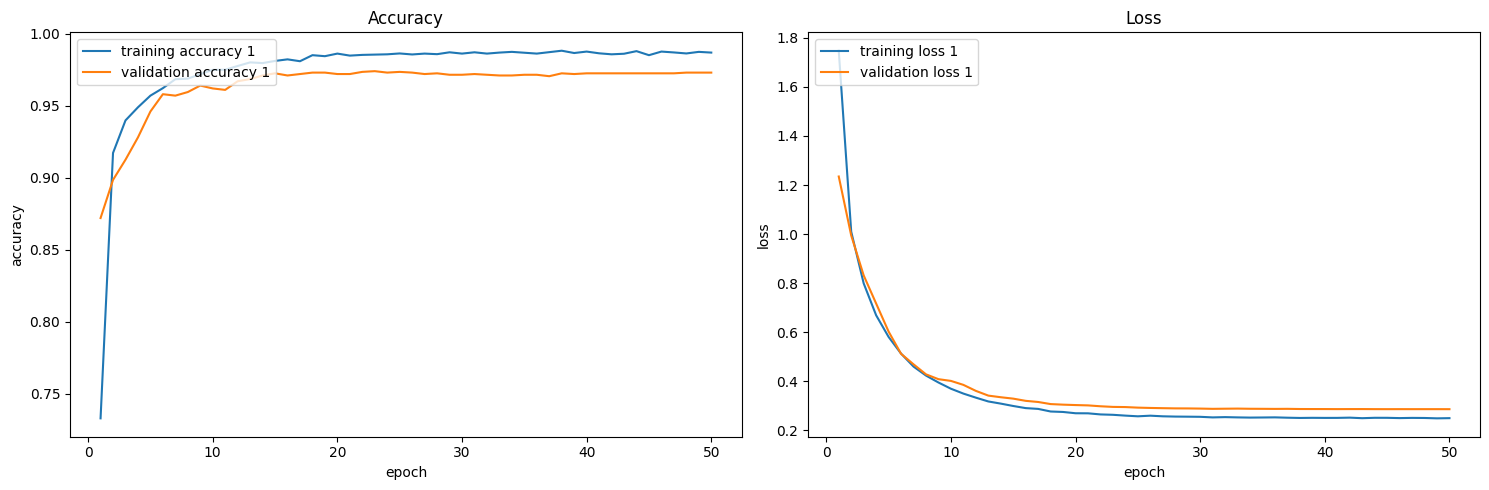

In [5]:
model.compile(
    loss=LOSS, 
    optimizer=OPTIMIZER,
    metrics=["accuracy"]
)

hist = model.fit(train_dataset, epochs=50, validation_data=valid_dataset)

visualization.training_history(hist)

## Loading Trained Model

In [6]:
model = keras.models.load_model(os.path.join('trained_models','g_cnn', '25000', 'training1.model.keras'))

## Evaluation

### Accuracy

In [7]:
loss, accuracy = model.evaluate(test_dataset)

print(f'{accuracy=:.4f}')
print(f'{loss=:.4f}')

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.9762 - loss: 0.2976
accuracy=0.9747
loss=0.3010


### Confusion Matrix

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


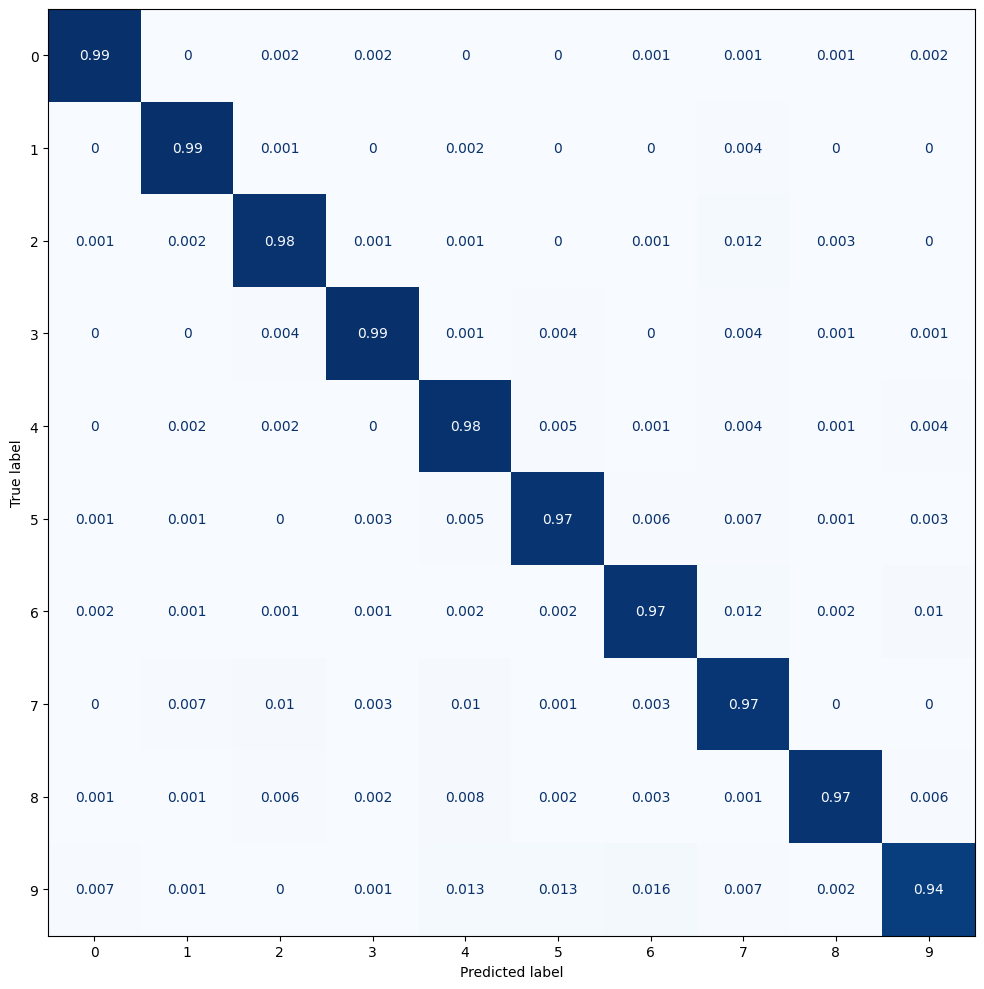

In [8]:
cm = utils.get_confusion_matrix(model, test_dataset, test_y, class_names=list(range(10)))
visualization.confusion_matrix(cm, class_names=list(range(10)))

## Kernel Visualization

In [ ]:
from ipywidgets import interact, Dropdown

# prepare widgets
conv_layers = [(layer.name, layer) for layer in model.layers if isinstance(layer, GConv)]
layerW = Dropdown(options=conv_layers)
in_channelW = Dropdown(description='in channel')
out_channelW = Dropdown(description='out channel')

def update_options(*args):
    """Updates the channel widgets when the layer changes."""
    layer = layerW.value
    in_channelW.options = range(layer.input.shape[-1])
    out_channelW.options = range(layer.output.shape[-1])
    
    if in_channelW.value not in in_channelW.options:
        in_channelW.value = 0
    if out_channelW.value not in out_channelW.options:
        out_channelW.value = 0
        
layerW.observe(update_options)

@interact(layer=layerW, in_channel=in_channelW, out_channel=out_channelW)
def show_filters(layer, in_channel=0, out_channel=0):
    """Shows the filters of the conv layer for the given input and output channel."""
    filters = layer.get_transformed_filters()
    in_rot_channels = filters.shape[-3]
    out_rot_channels = filters.shape[0]
    
    for in_rot in range(in_rot_channels):
        selected_filters = [filters[out_rot, :, :, in_rot, in_channel, out_channel] 
                            for out_rot in range(out_rot_channels)]
        visualization.image_grid(selected_filters, 
                                 [f'{out_rot=}' for out_rot in range(out_rot_channels)], 
                                 title=f'{in_rot=}')

## Feature Map Visualization

In [10]:
def layer_output(layer, inpt):
    """Computes the layer's output for the given model input."""
    layer_out = keras.Model(inputs=model.inputs, outputs=[layer.output])
    return layer_out(inpt[np.newaxis,:], training=False)[0].numpy()


In [ ]:
from ipywidgets import interact, Dropdown, FloatSlider, BoundedIntText

# prepare widgets
layerW = Dropdown(options = [(layer.name, layer) for layer in model.layers])
channelW = Dropdown()
imgW = BoundedIntText(min=0, max=len(test_x)-1, description='image nr')
rotW = FloatSlider(min=0, max=360, step=360/16, value=90, description='input rotation')

def update_options(*args):
    """Updates the channel widgets when the layer changes."""
    layer = layerW.value
    channelW.options = range(layer.output.shape[-1])
    
    if channelW.value not in channelW.options:
        channelW.value = 0
        
layerW.observe(update_options)

@interact(layer=layerW, channel=channelW, img_nr=imgW, rot=rotW)
def show_layer_output(layer, channel=0, img_nr=1, input_rot=90):
    """Shows the layer's output for both an unrotated and rotated version of the image."""
    # prepare input
    img = test_x[img_nr]
    img_rot = utils.rotate_image(img, input_rot)
    
    # calculate layer output
    out = layer_output(layer, img)[...,channel] # shape=[h,w,rot]
    out_rot = layer_output(layer, img_rot)[...,channel] # shape=[h,w,rot]
    
    # unify dimensions
    if len(out.shape) == 2:
        # adding rotation dimension: h,w -> h,w,rot
        out = out[..., np.newaxis]
        out_rot = out_rot[..., np.newaxis]
    if len(out.shape) == 1:
        # adding spatial dimensions: rot -> h,w,rot
        out = out[np.newaxis ,np.newaxis, :]
        out_rot = out_rot[np.newaxis, np.newaxis, :]
    if len(out.shape) == 0:
        # adding spatial and rotation dimensions: -> h,w,rot
        out = out[..., np.newaxis, np.newaxis, np.newaxis]
        out_rot = out_rot[..., np.newaxis, np.newaxis, np.newaxis]
        
    # show layer output
    rot_channels = out.shape[-1]
    visualization.image_grid([out[...,rot] for rot in range(rot_channels)], 
                             [f'{rot=}' for rot in range(rot_channels)],
                             title='original input')
    visualization.image_grid([out_rot[...,rot] for rot in range(rot_channels)], 
                             [f'{rot=}' for rot in range(rot_channels)],
                             title=f'{input_rot:.2f}° rotated input')
    

## Equivariance

In [ ]:
from ipywidgets import interact, FloatSlider, BoundedIntText

imgW = BoundedIntText(min=0, max=len(test_x)-1, description='image nr')
rotW = FloatSlider(min=0, max=360, step=360/16, value=90, description='input rotation')

@interact(img_nr=imgW, input_rot=rotW)
def show_equivariance(img_nr=0, input_rot=90):
    img = test_x[img_nr]
    print('digit:', test_y[img_nr])
    img_rot = utils.rotate_image(img, input_rot)

    out, out_rot = model(np.vstack([img, img_rot]), training=False)

    print('equal model output:', np.isclose(out, out_rot, rtol=1e-5, atol=1e-3).all())
    print('output distance:', np.linalg.norm(out-out_rot).round(3))

    visualization.image_grid([out[np.newaxis,:], out_rot[np.newaxis,:]], 
                            labels=['original input', '90° rotated input'], 
                            cols=1, figsize=(5,3))